# The Weather Outside is Weather

# Goal
- Explore historic data and discover weather patterns for Rangoon, Burma
- Utilize machine learning models to predict future weather patterns

# Executive Summary
- Historic data time frame: 1796 - 2013
- Temperate tempature:
    - Low 70s - Low 80s
- Rolling Average Model Performance: 3.6 RMSE

# Imports

In [1]:
import os
import pandas as pd
import numpy as np
from pydataset import data
import requests
from env import username, host, password

# modules
import env
import acquire as a
import prepare as p
import explore as e
import wrangle as w
import visual as viz

#model methods
import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing

#visual imports
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Acquire

- Acquired from Kaggle: 
    
    - Link: https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data
    - Used Global Land Temperatures by Major City file.
- 239177 rows. Each row represents a date of when the weather was observed.
- 7 columns. Each column are values the represent temperature, city, grid coordinates, and country

In [2]:
# Acquired data
df = a.acquire_rangoon()

# Set dat index
df = p.fix_index(df)

# Prepare
- Set date as the index.
- Normalized column names to be more python friendly.
- Dropped nulls.
    - 81 observations.
- Subset observatios for Rangoon, Burma.
    - remaining rows: 2613
- Convert from celsius to farenheit for readability.
- Split data into three sets (55/25/20): Train, Validate, and Test

In [3]:
# Split data
train, val, test = p.split_percent(df)

Train size: 1392 Validate size: 633 Test Size: 507


# Data Dictionary

| Feature | Definition |
| :-- | :-- |
| avg_temp | average temperature  |
| avg_temp_certainty | average amount of degrees difference from aveage temperature |
| city | city name|
| country | country name | 
| lat | latitude coordinate |
| lon | longitude coordinate |

# Glance into Rangoon's Data

In [4]:
# First five observations
df.head()

,avg_temp,avg_temp_certainty,city,country,lat,lon
date,,,,,,
1796-01-01,75.2900,2.256,Rangoon,Burma,16.87N,95.44E
1796-02-01,77.6678,1.606,Rangoon,Burma,16.87N,95.44E
1796-03-01,80.7242,2.168,Rangoon,Burma,16.87N,95.44E
1796-04-01,85.0946,1.584,Rangoon,Burma,16.87N,95.44E
1796-05-01,84.9758,1.634,Rangoon,Burma,16.87N,95.44E


# Explore

## Temperature over time

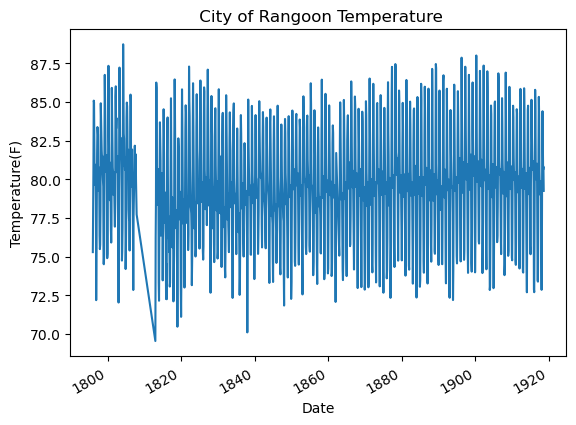

In [5]:
train.avg_temp.plot()
plt.ylabel('Temperature(F)')
plt.xlabel('Date')
plt.title(' City of Rangoon Temperature')
plt.show()

## Distribution of Temperature

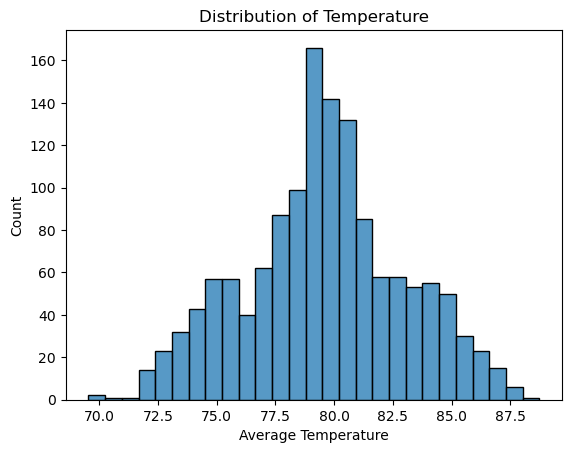

In [6]:
# Distribution of temp
sns.histplot(x='avg_temp', data=train)
plt.xlabel('Average Temperature')
plt.title('Distribution of Temperature')
plt.show()

## Monthly Average

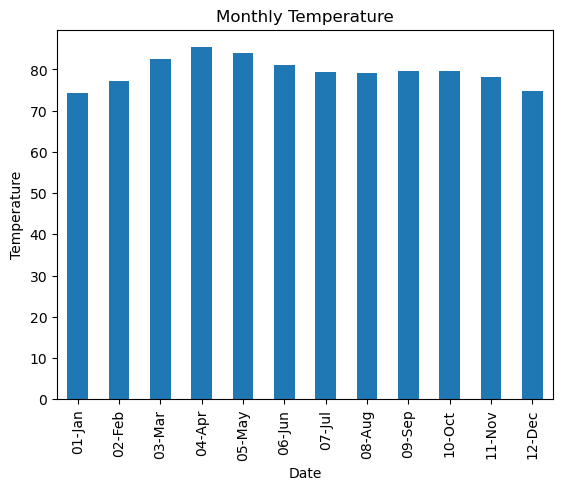

In [7]:
## Monthly Average Temperature
train.avg_temp.groupby(train.avg_temp.index.strftime('%m-%b')).mean().plot.bar()
plt.ylabel('Temperature')
plt.xlabel('Date')
plt.title('Monthly Temperature')
plt.show()

# Modeling 
**Three models tested:** Previous Cycle, Rolling Average, and Holts Seasonal.
- RMSE is the evaluation metric being used. Closer the value is to zero, the better the model performs

In [8]:
# Creating Cycle
c1 = train[train.index.year == 1917][5:][['avg_temp']]
c2 = train[train.index.year == 1918][:5][['avg_temp']]
cycle = pd.concat([c1,c2], axis=0)

# Twenty year cycle
twenty_year_cycle = pd.concat([cycle]*20, ignore_index=True)

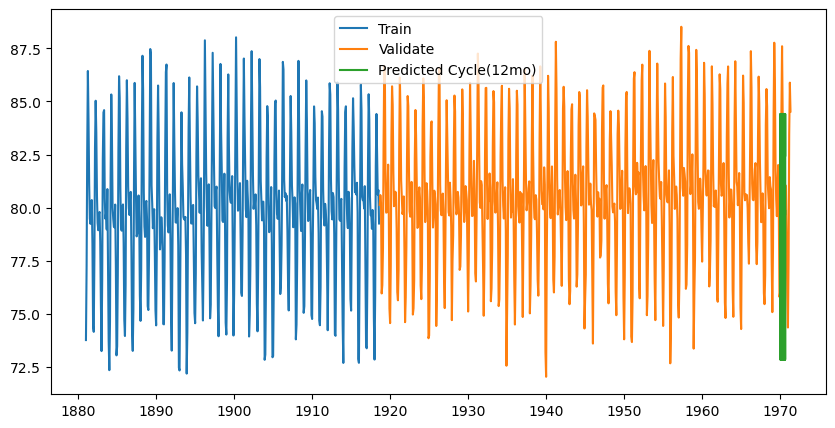

In [9]:
# Plot visual
plt.figure(figsize=(10,5))
plt.plot(train[train.index.year >1880]['avg_temp'], label='Train')
plt.plot(val.avg_temp, label='Validate')
plt.plot(twenty_year_cycle.avg_temp, label='Predicted Cycle(12mo)' )
plt.legend()
plt.show()

### Evaluate performance

In [10]:
# Make index equal length to evaluate
fifetree_year_cycle = pd.concat([cycle]*53, ignore_index=True)
fifetree_year_cycle = fifetree_year_cycle.drop(fifetree_year_cycle.tail(3).index)

In [11]:
# RMSE 
sse, mse, rmse, ess, tss = p.regression_errors2(val['avg_temp'], fifetree_year_cycle['avg_temp'])
print(round(rmse,2))

5.7


In [12]:
# DF to compare different models
compare = pd.DataFrame({'model': 'previous_cycle','rmse_val': [rmse]})
compare

,model,rmse_val
0,previous_cycle,5.703473


## Rolling Average

In [13]:
# Rolling average of last 12 months
yhat_df = e.rolling(train, val)

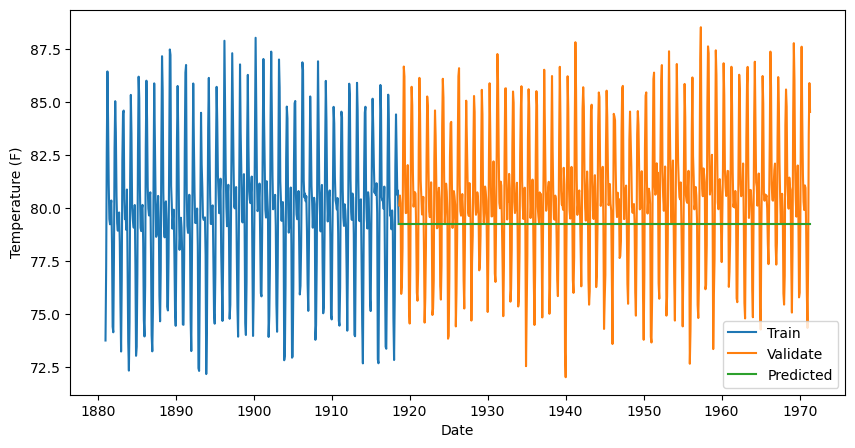

In [14]:
# Plot visual
viz.plot_rolling(train, val, yhat_df)

### Evaluate performance

In [15]:
sse, mse, rmse, ess, tss = p.regression_errors2(val['avg_temp'], yhat_df['avg_temp'])
print(round(rmse,2))

3.41


In [16]:
# Dataframe of of rolling average RMSE
r_avg_df = pd.DataFrame({'model': 'rolling_avg','rmse_val': [rmse]})

# Added to compare dataframe
compare = pd.concat([compare, r_avg_df], axis=0)
compare

,model,rmse_val
0,previous_cycle,5.703473
0,rolling_avg,3.414862


## Holts Seasonal

In [17]:
# Model Object
holts_seasonal = ExponentialSmoothing(train.avg_temp, seasonal_periods=633,\
                                      trend='add', seasonal='add', damped=True).fit()

In [18]:
# Forecast
d = holts_seasonal.forecast(val.shape[0])
# Convert to dataframe
holts = pd.DataFrame({'avg_temp': d.values}, index=val.index)

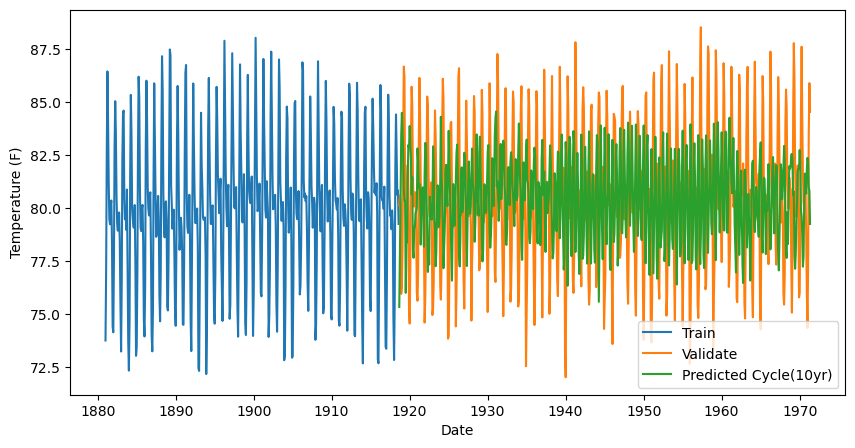

In [19]:
# Plot visual
plt.figure(figsize=(10,5))
plt.plot(train[train.index.year >1880]['avg_temp'], label='Train')
plt.plot(val.avg_temp, label='Validate')
plt.plot(holts.avg_temp, label='Predicted Cycle(10yr)',   )
plt.ylabel('Temperature (F)')
plt.xlabel('Date')
plt.legend()
plt.show()

### Evaluate performance

In [20]:
# Calculate rmse
sse, mse, rmse, ess, tss = p.regression_errors2(val['avg_temp'], holts_seasonal.forecast(val.shape[0]))
# Turn in to dataframe
a = pd.DataFrame({'model': 'holts_seasonal', 'rmse_val': [rmse]})
# Add to compare dataframe
compare = pd.concat([compare, a], axis=0, ignore_index=True)
compare

,model,rmse_val
0,previous_cycle,5.703473
1,rolling_avg,3.414862
2,holts_seasonal,4.535919


## Compare Models

In [22]:
compare

,model,rmse_val
0,previous_cycle,5.703473
1,rolling_avg,3.414862
2,holts_seasonal,4.535919


**Rolling Average is the best performing model. It will move on to the test data set**

## Test data set: Rolling Average

In [23]:
# Creating rolling average for test
rolling_test = test['avg_temp'].rolling(12).mean()[-1]
# Convert to datafrmae
test_df = pd.DataFrame({'avg_temp': rolling_test}, index= test.index)

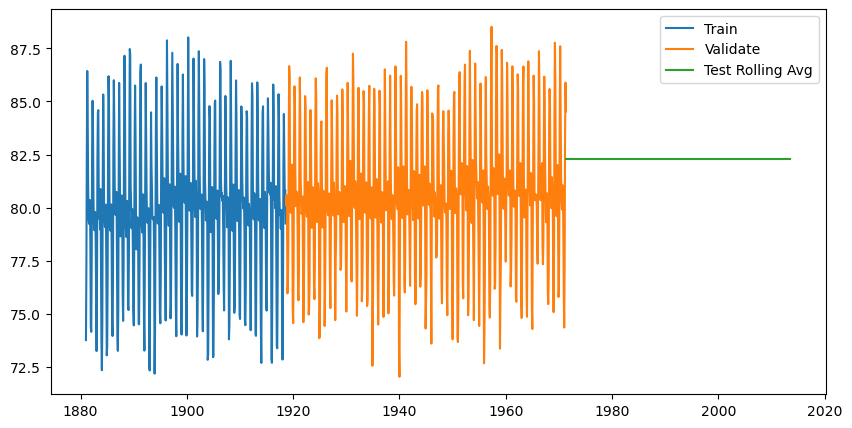

In [24]:
# Plot visual
plt.figure(figsize=(10,5))
plt.plot(train[train.index.year >1880]['avg_temp'], label='Train')
plt.plot(val.avg_temp, label='Validate')
plt.plot(test_df.avg_temp, label='Test Rolling Avg')
plt.legend()

**Looks Excellent!**

### Evaluate Test data

In [27]:
# Dataframe of rolling test
rmse_compare_test = pd.DataFrame({'avg_temp': rolling_test}, index= val.index)
# RMSE value
sse, mse, rmse, ess, tss = p.regression_errors2(val['avg_temp'], rmse_compare_test['avg_temp'])
# Convert to dataframe
a = pd.DataFrame({'model': 'Test_moving_avg', 'rmse_val': [rmse]})
# Add to compare
compare = pd.concat([compare,a],axis=0)
compare

,model,rmse_val
0,previous_cycle,5.703473
1,rolling_avg,3.414862
2,holts_seasonal,4.535919
0,Test_moving_avg,3.584799


**Test peformed slightly worse than validate, but still better than other models**

# Conclusion

**Explore:**
- Rangoon's seems to have a temperate climate with average temperatures ranging from low 70s to low 80s. 
- Records go back all the way to 1796, which brings question to how accurate those measurements are. 

**Model Performance:**
- Rolling Average model on test performed 0.16 worse when compared to the validate data set. Although, it was still able to perform 2.12 better than Previous Cycle and 0.95 better than Holts Seasonal. 

# Next Steps

- Use differnt models such as Holts Linear to predict future weather patterns.
- Investigate how average temperature certainty fluctuates throught the years.
- Try to find another data source that also has weather recordings to validate this data set. 